In [11]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import os

## Data Transform

In [12]:
# 특정 테이블을 추출하는 함수
def extract_table_data(table, row_indices):
    tbody = table.find("tbody")
    rows = tbody.find_all("tr")

    data = []
    for index in row_indices:
        row = rows[index]
        th_elements = row.find_all("th")
        td_elements = row.find_all("td")

        th_text = th_elements[0].get_text(strip=True)
        td_numbers = [int(td.get_text(strip=True)) for td in td_elements]

        data.append((th_text, td_numbers))

    return data


def create_deliberation_result_data_dict(
    semester, review_count, victim_student_count, perpetrator_student_count
):
    data = {
        "연도": semester,
        "심의 건수": int(review_count),
        "피해학생 수": int(victim_student_count),
        "가해학생 수": int(perpetrator_student_count),
    }
    return data


def create_violence_data_dict(semester, cells):
    data = {
        "연도": semester,
        "신체폭력": int(cells[0].get_text(strip=True)),
        "언어폭력": int(cells[1].get_text(strip=True)),
        "금품갈취": int(cells[2].get_text(strip=True)),
        "강요": int(cells[3].get_text(strip=True)),
        "따돌림": int(cells[4].get_text(strip=True)),
        "성폭력": int(cells[5].get_text(strip=True)),
        "사이버푹력": int(cells[6].get_text(strip=True)),
        "기타": int(cells[7].get_text(strip=True)),
    }
    return data


def create_violence_student_result_data_dict(data_rows):
    (
        (first_semester, numbers1),
        (first_semester_complete, numbers2),
        (second_semester, numbers4),
        (second_semester_complete, numbers5),
    ) = data_rows

    data = {
        "학기": [first_semester, second_semester],
        "서면사과 - 위원회 요청": [numbers1[0], numbers4[0]],
        "서면사과 - 심의 완료": [numbers2[0], numbers5[0]],
        "접촉·협박·보복행위 금지 - 위원회 요청": [numbers1[1], numbers4[1]],
        "접촉·협박·보복행위 금지 - 심의 완료": [numbers2[1], numbers5[1]],
        "학교봉사 - 위원회 요청": [numbers1[2], numbers4[2]],
        "학교봉사 - 심의 완료": [numbers2[2], numbers5[2]],
        "사회봉사 - 위원회 요청": [numbers1[3], numbers4[3]],
        "사회봉사 - 심의 완료": [numbers2[3], numbers5[3]],
        "특별교육 이수 또는 심리치료 - 위원회 요청": [numbers1[4], numbers4[4]],
        "특별교육 이수 또는 심리치료 - 심의 완료": [numbers2[4], numbers5[4]],
        "출석정지 - 위원회 요청": [numbers1[5], numbers4[5]],
        "출석정지 - 심의 완료": [numbers2[5], numbers5[5]],
        "학급교체 - 위원회 요청": [numbers1[6], numbers4[6]],
        "학급교체 - 심의 완료": [numbers2[6], numbers5[6]],
        "전학 - 위원회 요청": [numbers1[7], numbers4[7]],
        "전학 - 심의 완료": [numbers2[7], numbers5[7]],
        "퇴학처분 - 위원회 요청": [numbers1[8], numbers4[8]],
        "퇴학처분 - 심의 완료": [numbers2[8], numbers5[8]],
        "합계 - 위원회 요청": [numbers1[9], numbers4[9]],
        "합계 - 심의 완료": [numbers2[9], numbers5[9]],
    }
    return data


# '선택된 연도'에서 연도를 추출하고 1년을 빼서 이전 연도 계산
def get_previous_academic_year(current_year):
    year = int(current_year.replace("년", ""))
    previous_year = year - 1
    return [f"{previous_year}학년도 1학기", f"{previous_year}학년도 2학기"]


def create_school_data(
    school_name,
    num_boys,
    num_girls,
    num_teachers,
    address_info,
    class_size,
    selected_option_text,
):
    data = {
        "학교이름": [school_name],
        "남학생 수": [num_boys],
        "여학생 수": [num_girls],
        "교원 수": [num_teachers],
        "주소": [address_info],
        "학급당 학생수": [class_size],
        "선택된 연도": [selected_option_text],
    }
    return data

In [13]:
folder_path = "school_html_files"

# 폴더 내의 모든 파일 목록 가져오기
file_list = os.listdir(folder_path)

# HTML 파일만 필터링
html_files = [f for f in file_list if f.endswith(".html")]

# 데이터프레임을 저장할 리스트
dataframes = []

# 각 HTML 파일 읽기
for html_file in html_files:
    file_path = os.path.join(folder_path, html_file)
    with open(file_path, "r", encoding="utf-8") as file:
        html_content = file.read()

    soup = BeautifulSoup(html_content, "html.parser")

    # 학교 이름 추출
    basic_data_div = soup.find("div", class_="basic_data")
    p_tag = basic_data_div.find("p")
    for span in p_tag.find_all("span"):
        span.extract()
    for button in p_tag.find_all("button"):
        button.extract()
    school_name = p_tag.get_text(strip=True)

    # 학생수, 교원수, 주소 정보 추출
    md_spans = soup.find_all("span", class_="md")
    student_info = None
    teacher_info = None
    address_info = None

    for md_span in md_spans:
        mt_span = md_span.find("span", class_="mt")
        if mt_span:
            text = mt_span.get_text(strip=True)
            if "학생수" in text:
                student_info = md_span.get_text(strip=True)
            elif "교원수" in text:
                teacher_info = md_span.get_text(strip=True)
            elif "주소" in text:
                address_info = md_span.get_text(strip=True)

    student_numbers = (
        re.findall(r"\d+", student_info.replace(",", "").strip())
        if student_info
        else []
    )
    num_boys = student_numbers[1] if len(student_numbers) >= 3 else None
    num_girls = student_numbers[2] if len(student_numbers) >= 3 else None
    num_teachers = (
        re.findall(r"\d+", teacher_info.replace(",", "").strip())[0]
        if teacher_info
        else None
    )
    address_info = address_info.split(":")[1].strip() if address_info else None

    # 학급당 학생수 추출
    boxes = soup.find_all("div", class_="box")
    class_size = None

    for box in boxes:
        caption = box.find("caption")
        if caption:
            caption_text = " ".join(caption.get_text(separator=" ").split())
            if (
                "차트의 대체 텍스트로 교원1인당 학생수, 학급당학생수 의 정보를 제공한다."
                in caption_text
            ):
                tspans = box.find_all("tspan")
                for i, tspan in enumerate(tspans):
                    if "학급당학생수" in tspan.get_text(strip=True):
                        if i + 2 < len(tspans):
                            class_size = tspans[i + 2].get_text(strip=True)
                            break
                if class_size:
                    break

    # 선택된 연도 추출
    select_tag = soup.find("select", id="gsYear")
    options = select_tag.find_all("option")
    selected_option_text = None
    for option in options:
        if option.has_attr("selected"):
            selected_option_text = option.get_text(strip=True)
            break

    school_df = pd.DataFrame(
        create_school_data(
            school_name,
            num_boys,
            num_girls,
            num_teachers,
            address_info,
            class_size,
            selected_option_text,
        )
    )

    # 심의 결과 테이블 추출
    tables = soup.find_all("table")
    deliberation_result_table = tables[4]
    tbody = deliberation_result_table.find("tbody")
    rows = tbody.find_all("tr")

    deliberation_result = []
    for row in rows[2:]:
        cells = row.find_all("td")
        semester = row.find("th", scope="row").get_text(strip=True)
        review_count = cells[0].get_text(strip=True)
        victim_student_count = cells[2].get_text(strip=True)
        perpetrator_student_count = cells[4].get_text(strip=True)
        deliberation_result_data = create_deliberation_result_data_dict(
            semester, review_count, victim_student_count, perpetrator_student_count
        )
        deliberation_result.append(deliberation_result_data)

    deliberation_result_df = pd.DataFrame(deliberation_result)

    # 폭력 유형별 테이블 추출
    violence_category = tables[5]
    tbody = violence_category.find("tbody")
    header_row = tbody.find_all("tr")[0]
    headers = [th.get_text(strip=True) for th in header_row.find_all("th")]
    rows = tbody.find_all("tr")[1:]

    violence_data_list = []
    for row in rows:
        cells = row.find_all("td")
        semester = row.find("th", scope="row").get_text(strip=True)

        violence_result_data = create_violence_data_dict(semester, cells)

        violence_data_list.append(violence_result_data)

    violence_df = pd.DataFrame(violence_data_list)

    # 가해학생 선도·교육조치 현황 추출
    violence_student_result = tables[7]
    violence = extract_table_data(violence_student_result, [1, 2, 4, 5])

    violence_student_result = create_violence_student_result_data_dict(violence)
    violence_student_result_df = pd.DataFrame(violence_student_result)

    """
    데이터 병합
    """

    # 원본 DataFrame의 '선택된 연도'에서 이전 학기 정보를 얻음
    previous_years = get_previous_academic_year(school_df["선택된 연도"][0])

    # 원본 DataFrame 복제
    df1 = school_df.copy()
    df2 = school_df.copy()

    # 새로운 학기 정보로 업데이트
    df1["연도"] = previous_years[0]
    df2["연도"] = previous_years[1]

    # 원본 DataFrame과 복제된 DataFrame을 병합
    school_info_df = pd.concat([df1, df2], ignore_index=True)

    # semester와 학기 컬럼명을 일치시키기 위해 이름을 변경
    violence_student_result_df = violence_student_result_df.rename(
        columns={"학기": "연도"}
    )
    # 각 DataFrame을 병합
    merged_df = pd.merge(school_info_df, deliberation_result_df, on="연도", how="left")
    merged_df = pd.merge(merged_df, violence_df, on="연도", how="left")
    merged_df = pd.merge(merged_df, violence_student_result_df, on="연도", how="left")

    # 데이터프레임을 리스트에 추가
    dataframes.append(merged_df)

# 모든 데이터프레임을 하나로 결합
df = pd.concat(dataframes, ignore_index=True)

### 중학교로 한정된 데이터 가져오기

In [14]:
# elementary_df = df[df['학교이름'].str.contains("초등학교")]
# high_df = df[df['학교이름'].str.contains("고등학교")]

middle_df = df[df["학교이름"].str.contains("중학교")]

### "구" column 추가

In [15]:
# '주소' 컬럼에서 '구' 정보 추출
middle_df["구"] = middle_df["주소"].str.extract(r"서울특별시\s(\S+구)")

/var/folders/14/2vn0vwzj29zb97jgpbhnrr_00000gn/T/ipykernel_61366/2578990015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_df["구"] = middle_df["주소"].str.extract(r"서울특별시\s(\S+구)")


### 구별 중학교 학교폭력 심의 결과 describe()

In [16]:
# '학교이름', '심의 건수', '구' 컬럼만을 선택하여 새로운 데이터프레임 생성
school_review_df = middle_df[["학교이름", "심의 건수", "구"]]

# '구' 기준으로 그룹화하고, 그룹별로 기술통계를 계산
grouped_stats_df = school_review_df.groupby("구").describe()

# 멀티인덱스의 첫 번째 레벨을 드롭하여 컬럼 이름을 간단히 만듦
grouped_stats_df.columns = grouped_stats_df.columns.droplevel()

# 인덱스를 초기화하여 '구'를 데이터프레임의 컬럼으로 변경
grouped_stats_df = grouped_stats_df.reset_index()

# 평균 값을 기준으로 오름차순 정렬
grouped_stats_df = grouped_stats_df.sort_values(by="mean").reset_index(drop=True)

grouped_stats_df

,구,count,mean,std,min,25%,50%,75%,max
0,중구,8.0,0.750000,1.388730,0.0,0.00,0.0,1.00,4.0
1,서대문구,20.0,1.150000,1.268028,0.0,0.00,1.0,2.00,4.0
2,영등포구,18.0,1.277778,1.601674,0.0,0.00,1.0,1.75,5.0
3,종로구,16.0,1.437500,1.787689,0.0,0.00,1.0,2.00,6.0
4,동작구,32.0,1.531250,1.645804,0.0,0.00,1.0,2.00,7.0
5,성북구,18.0,1.666667,1.571810,0.0,0.25,1.0,2.75,5.0
6,마포구,16.0,1.750000,2.081666,0.0,0.00,1.0,2.00,7.0
7,동대문구,18.0,1.777778,1.628986,0.0,1.00,1.5,2.00,6.0
8,강서구,18.0,1.833333,1.653872,0.0,1.00,1.5,2.00,6.0
9,강동구,14.0,1.857143,1.657484,0.0,0.25,2.0,2.75,5.0


### 시각화

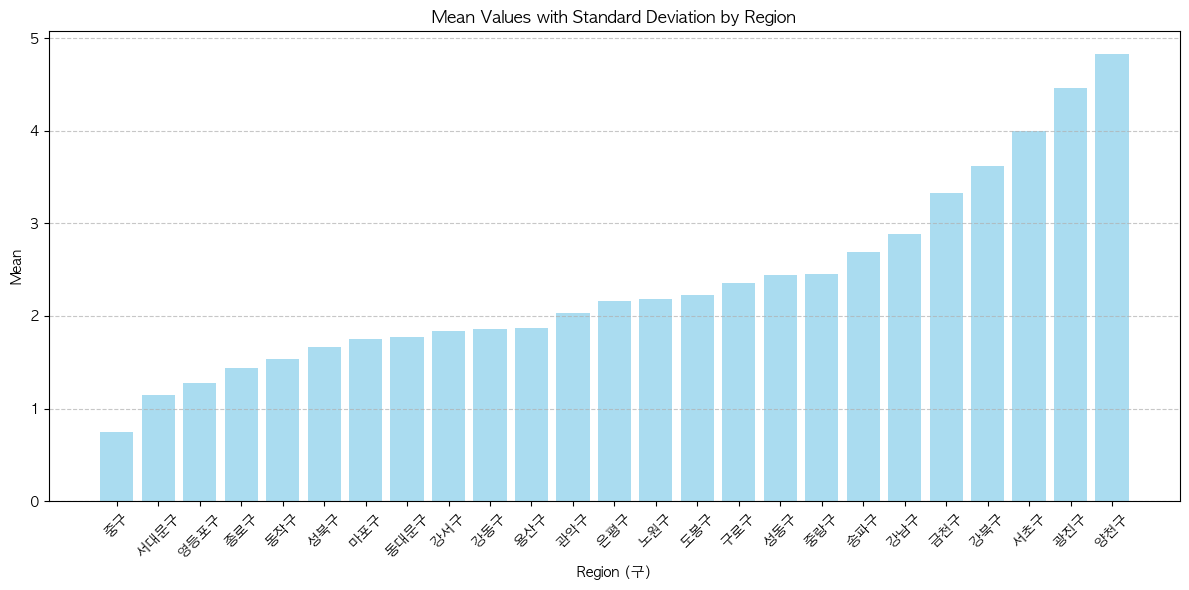

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 기호가 깨지는 현상 방지

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(
    grouped_stats_df["구"],
    grouped_stats_df["mean"],
    capsize=5,
    color="skyblue",
    alpha=0.7,
)
plt.title("Mean Values with Standard Deviation by Region")
plt.xlabel("Region (구)")
plt.ylabel("Mean")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1년간 학교폭력 심의건수가 0건인 학교, 그 학교가 포함된 구의 평균 학교폭력 심의 건수

In [19]:
# 심의 건수가 0인 학교 데이터만 추출
clean_middle_df = middle_df[middle_df["심의 건수"] == 0]

# 학교 이름별로 그룹화 후, 2개 이상의 레코드가 있는 학교만 필터링
clean_middle_df = clean_middle_df.groupby("학교이름").filter(lambda x: len(x) > 1)

# 학교 이름 기준으로 중복되는 행 제거 후, 인덱스 재설정
clean_middle_df = clean_middle_df.drop_duplicates(subset="학교이름").reset_index(
    drop=True
)

# 구 정보를 포함한 평균 값과 결합
merged_df = pd.merge(
    clean_middle_df, grouped_stats_df[["구", "mean"]], on="구", how="left"
)

# 필요한 열만 선택하고, 평균 값 기준으로 정렬
clean_middle_result_df = merged_df[["학교이름", "mean", "구"]]
clean_middle_result_df = clean_middle_result_df.sort_values(by="mean").reset_index(
    drop=True
)

clean_middle_result_df

,학교이름,mean,구
0,한양중학교,0.750000,중구
1,한성중학교,1.150000,서대문구
2,중앙여자중학교,1.150000,서대문구
3,영원중학교,1.277778,영등포구
4,덕성여자중학교,1.437500,종로구
5,국사봉중학교,1.531250,동작구
6,성신여자중학교,1.666667,성북구
7,정화여자중학교,1.777778,동대문구
8,용산중학교,1.875000,용산구
9,남강중학교,2.035714,관악구
